In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

## Uploading and preprocessing data

In [2]:
df = pd.read_csv('data/air_data_clean.csv')
df['date_time']=pd.to_datetime(df['date_time'], origin='1899-12-30', unit='D')

df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y')

# Replace '<Samp' values with 0
df = df.replace('<Samp', 0)

# Convert all non-numeric values (except dates) to NaN
numeric_columns = df.columns[1:]  # All columns except the date column
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Convert negative values to 0
df[numeric_columns] = df[numeric_columns].clip(lower=0)
    
# Calculate row means excluding NaN values
# axis=1 means calculate across columns
# skipna=True means ignore NaN values   
df['CO_Israel'] = df[numeric_columns].mean(axis=1, skipna=True)
df['half_month'] = df['date_time'].dt.day.apply(lambda x: 1 if x <= 15 else 2)

In [3]:
# transform daily data to half-monthly data

df_downsampled = df.groupby([
        df['date_time'].dt.year.rename('year'),
        df['date_time'].dt.month.rename('month'),
        'half_month'
    ])[df.columns[1:-1]].mean().reset_index()

# Create proper datetime for the downsampled data (using the 1st and 16th of each month)
df_downsampled['date'] = pd.to_datetime(
    df_downsampled.apply(
        lambda x: f"{int(x['year'])}-{int(x['month'])}-{1 if x['half_month']==1 else 16}",
        axis=1
    ))

In [4]:
air = df_downsampled.drop(["year", "month", "half_month"], axis=1)
air = air[["date", "CO_Israel", *air.columns.difference(["date", "CO_Israel"])]]
air_longer = air.melt(id_vars=['date'], var_name='station', value_name='CO_level')

In [23]:
# extract trend for each station
def extract_decomposition(group, period_months):
    group = group.dropna(subset=['CO_level'])
    decomposition = seasonal_decompose(group['CO_level'], period=period_months, model='additive', extrapolate_trend='freq')
    group['Observed'] = decomposition.observed
    group['Trend'] = decomposition.trend
    group['Seasonal'] = decomposition.seasonal
    return group

In [27]:
air_decomposition = (
    air_longer.set_index("station")
    .groupby("station", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=24)
    .reset_index()
)

In [38]:
# Plot using FacetGrid
def plot_spectral_facets(air_decomposition_dat, spectral_component, cycle, save_as_file = False):
    g = sns.FacetGrid(air_decomposition_dat, col="station", col_wrap=3,  sharey=True, sharex=True, height=4, aspect=1.5)
    g.map(sns.lineplot, "date", spectral_component)
    
    # Add title and adjust layout
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle("{} Component of Spectral Decomposition for Each Monitoring Station ({})".format(spectral_component, cycle))

    if save_as_file:
        plt.savefig("{}_{}.png".format(cycle, spectral_component), dpi=300, bbox_inches='tight')
    
    plt.show()

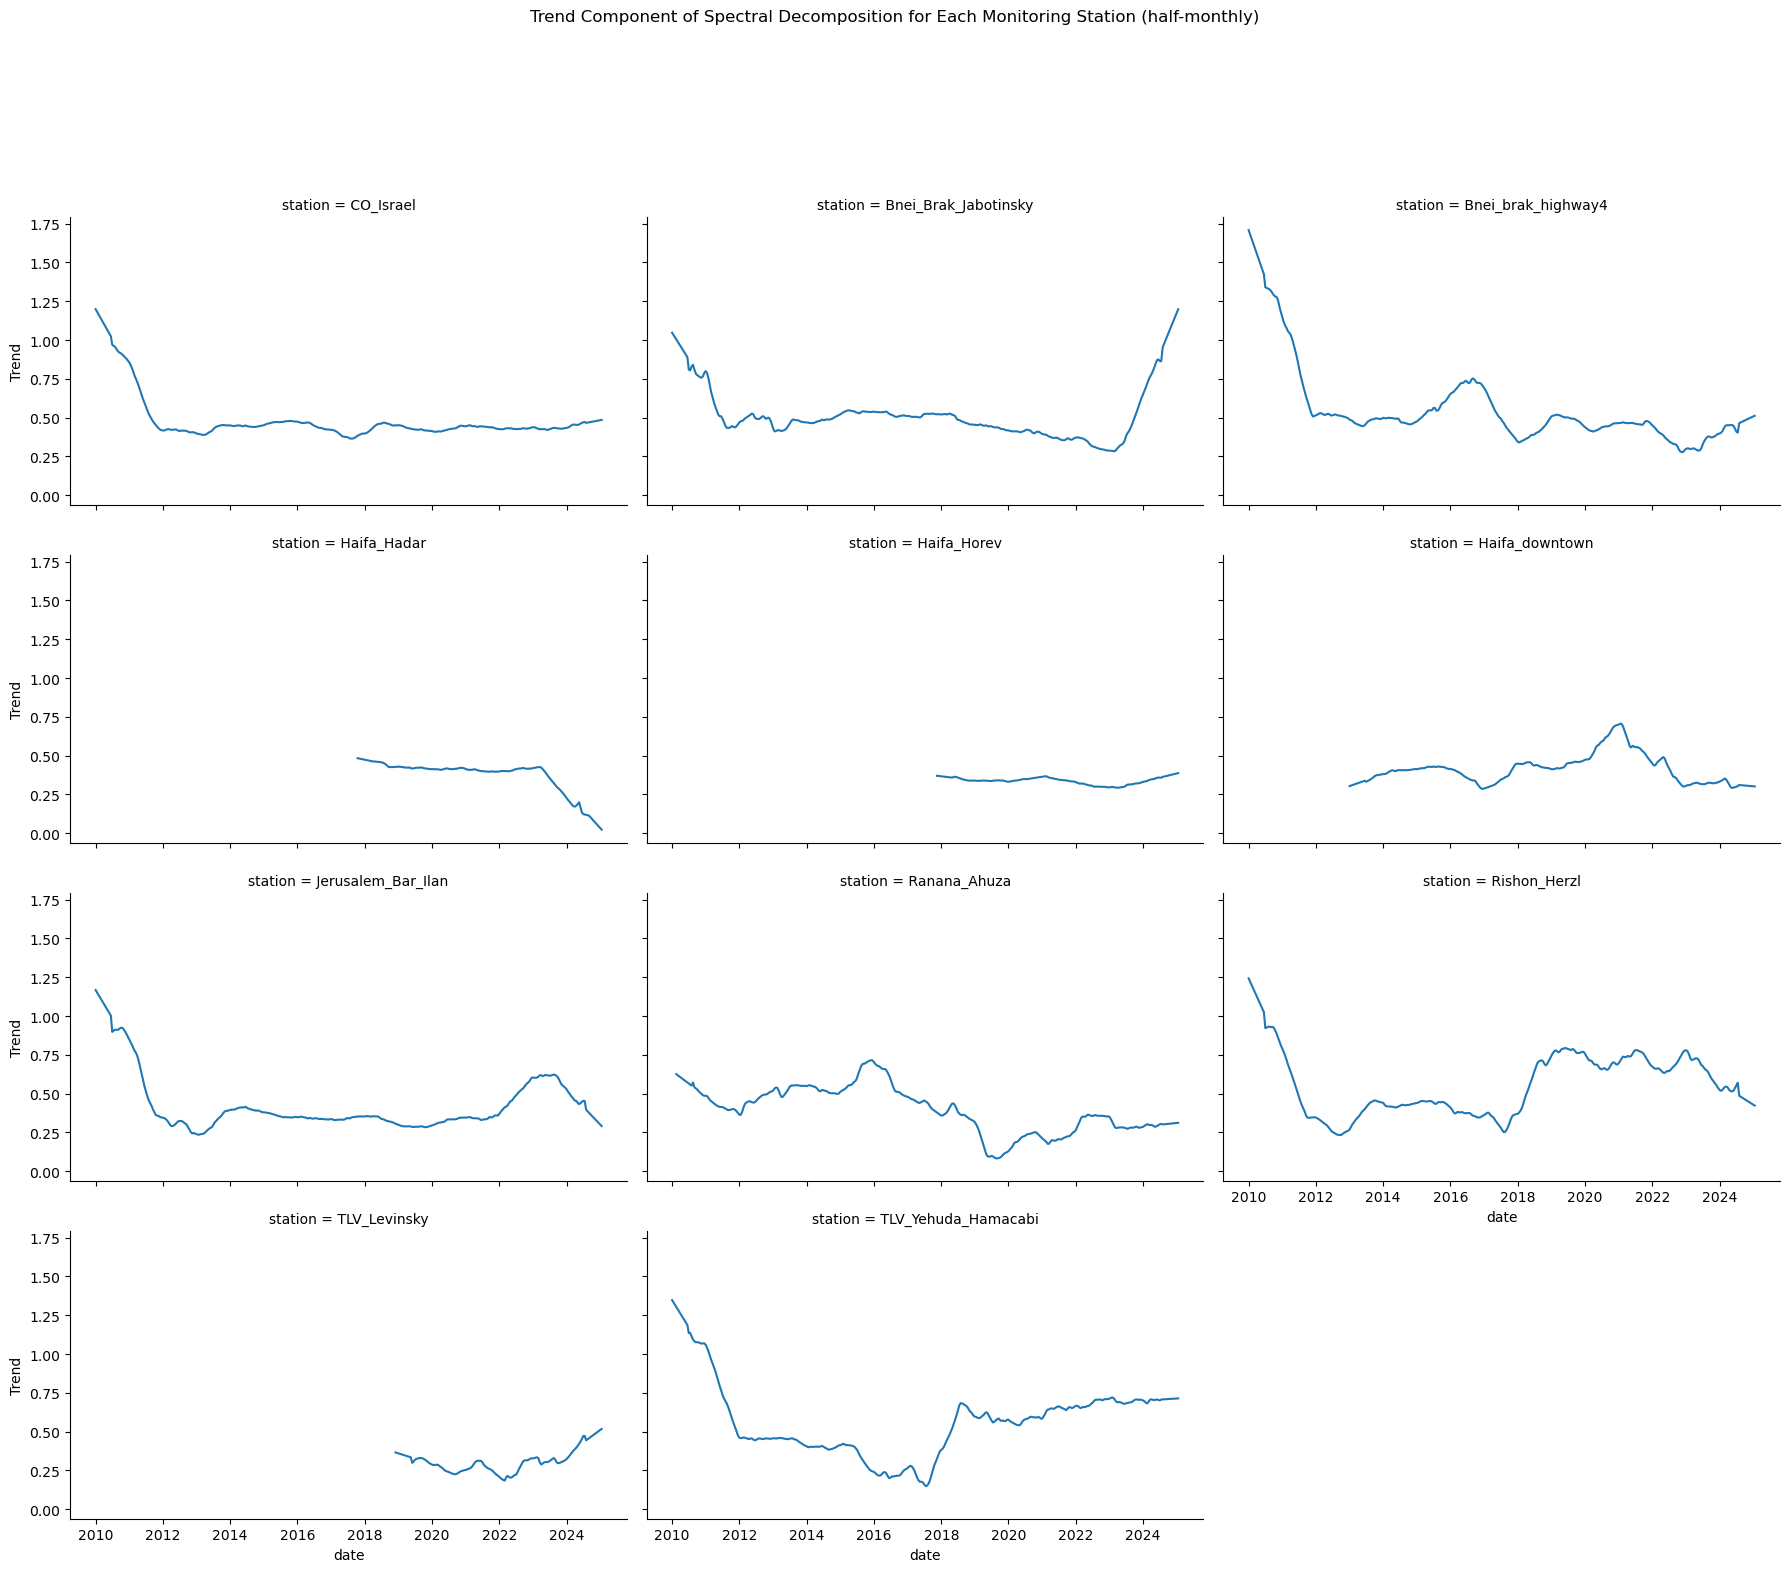

In [39]:
plot_spectral_facets(air_decomposition, "Trend", "half-monthly")

While all monitoring stations active at 2010 shows a significant decrease in pollution from 2010 to 2012, the monotonic trend observed afterwards in the state-average data is not consistently reflected at the individual station level. For example, the stations at TLV - Yehuda Hamacabi and Rishon - Herzl exhibits a substantial increase in pollution at 2018, with a similar but milder rise observed Haifa Downtown that same year. Towards 2024, some stations, such as those in Bnei Brak, shows increasing pollution levels, whereas others, including Rishon, Jerusalem, and Haifa Hadar, indicate a decline. 

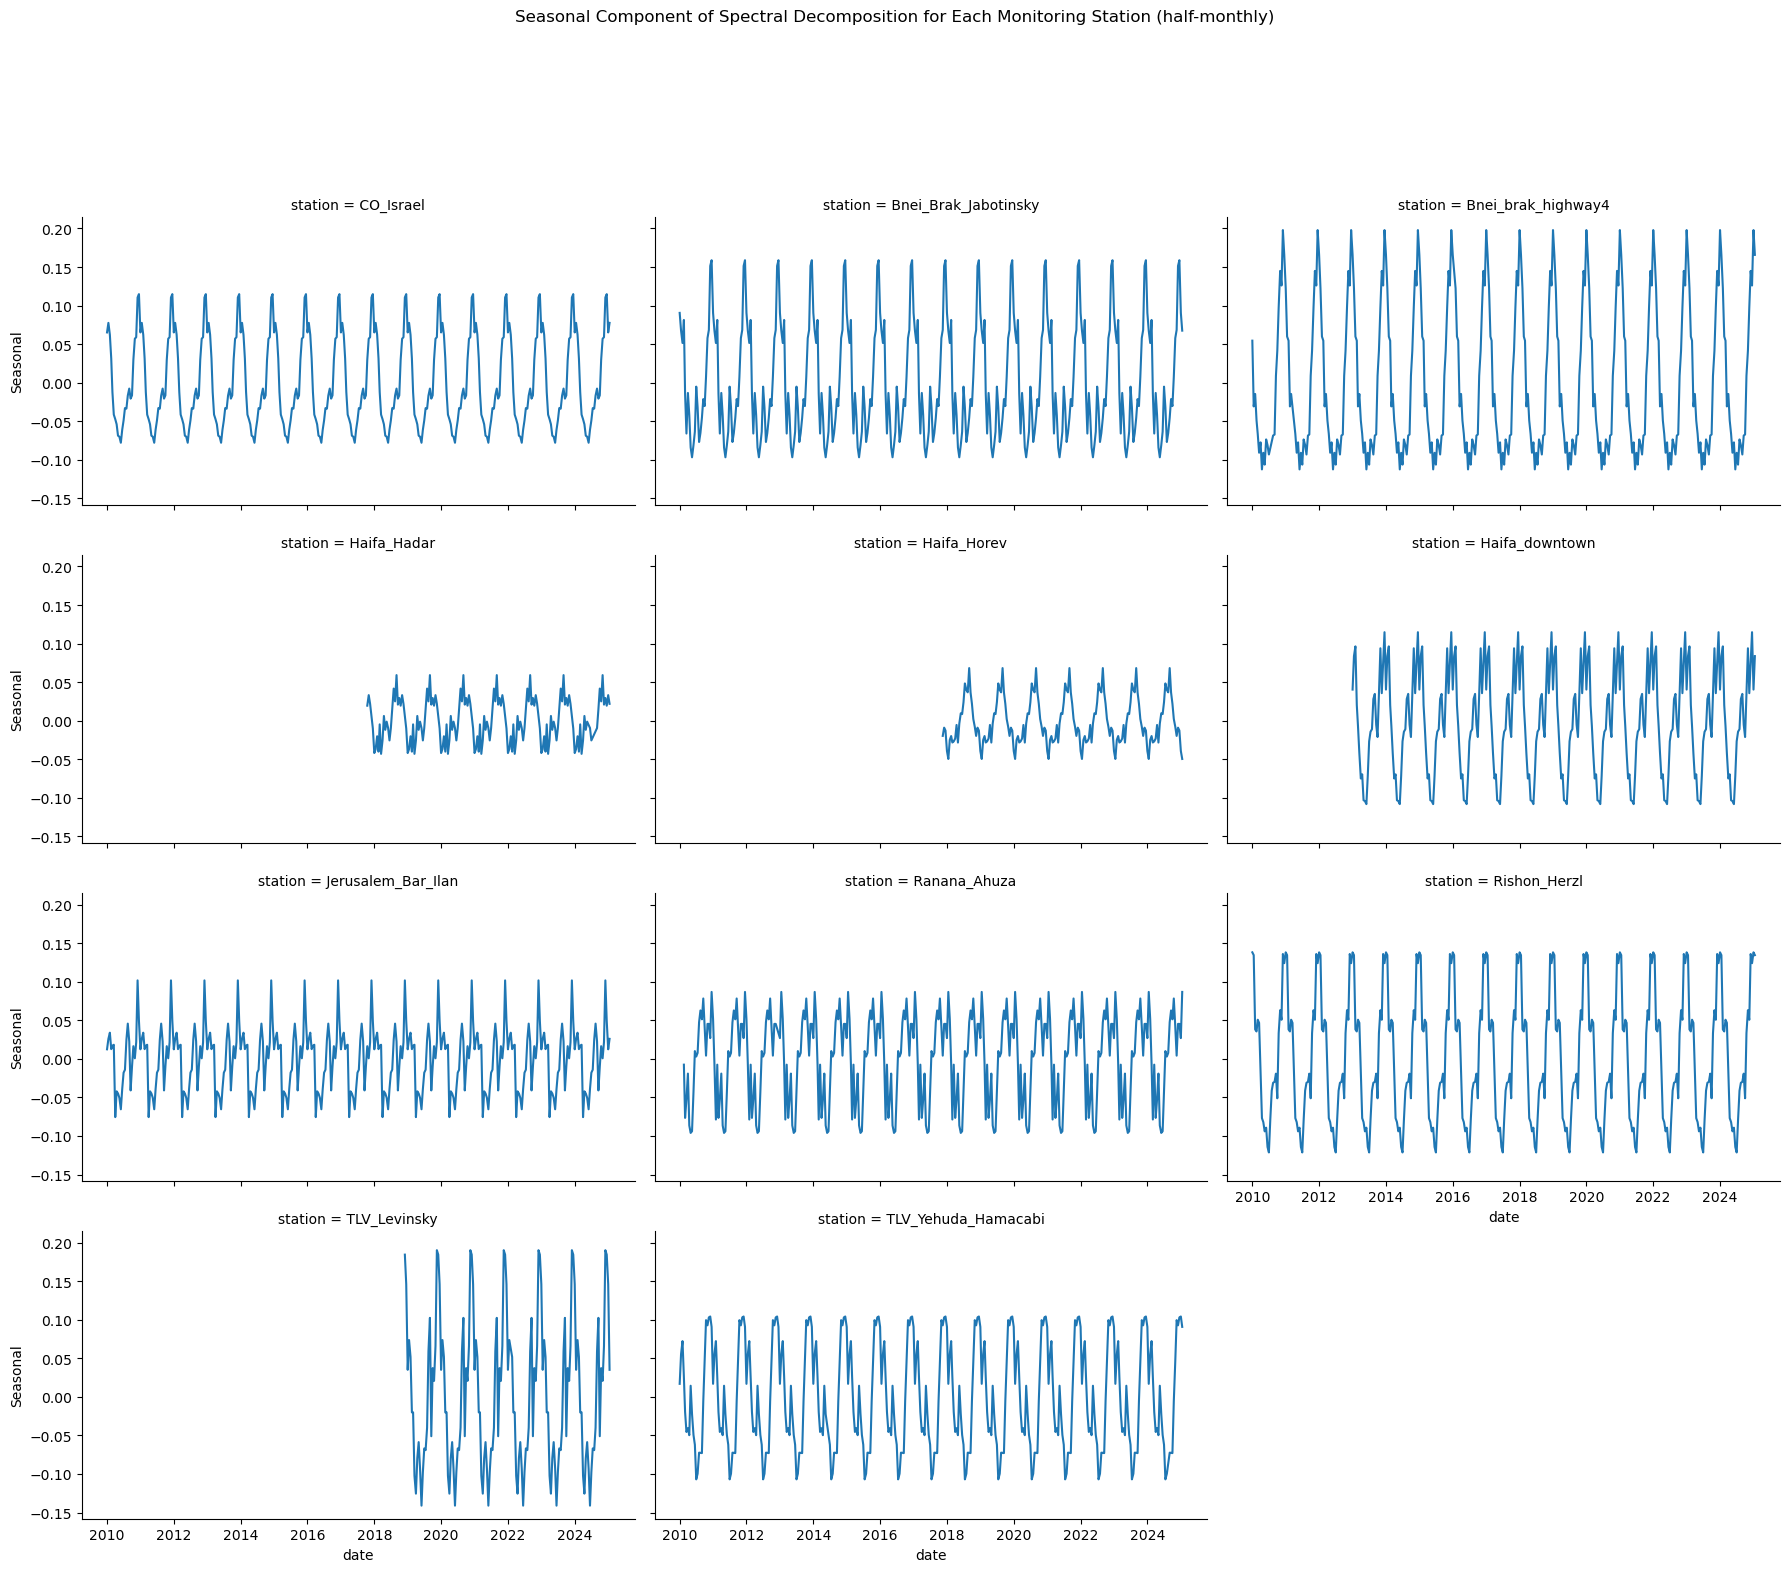

In [40]:
plot_spectral_facets(air_decomposition, "Seasonal", "half-monthly")

In [9]:
def plot_spectral(df, spectral_component):
    plt.figure(figsize = (12, 6))
    sns.lineplot(data = df, x="date", y=spectral_component, hue = "station")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Year")
    plt.ylabel(spectral_component)
    plt.title("{} component of spectral decomposition for all monitoring stations".format(spectral_component))
    plt.show()

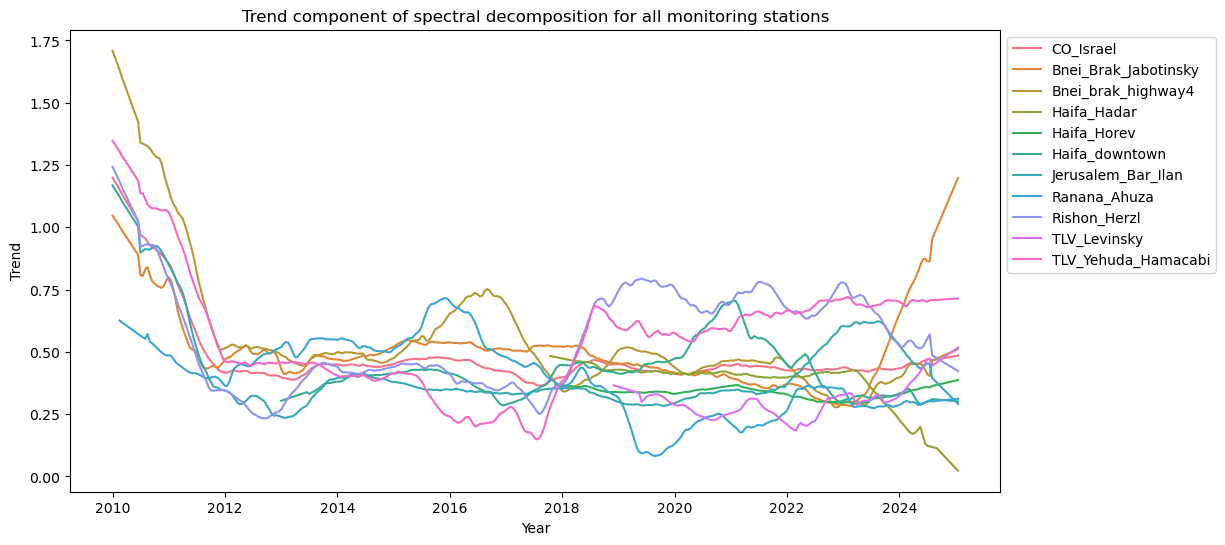

In [10]:
plot_spectral(air_decomposition, "Trend")

In [12]:
subset_center = air_decomposition[air_decomposition['station'].str.contains('Bnei_Brak|Israel|TLV|Rishon|Rana', case=False, na = False)]

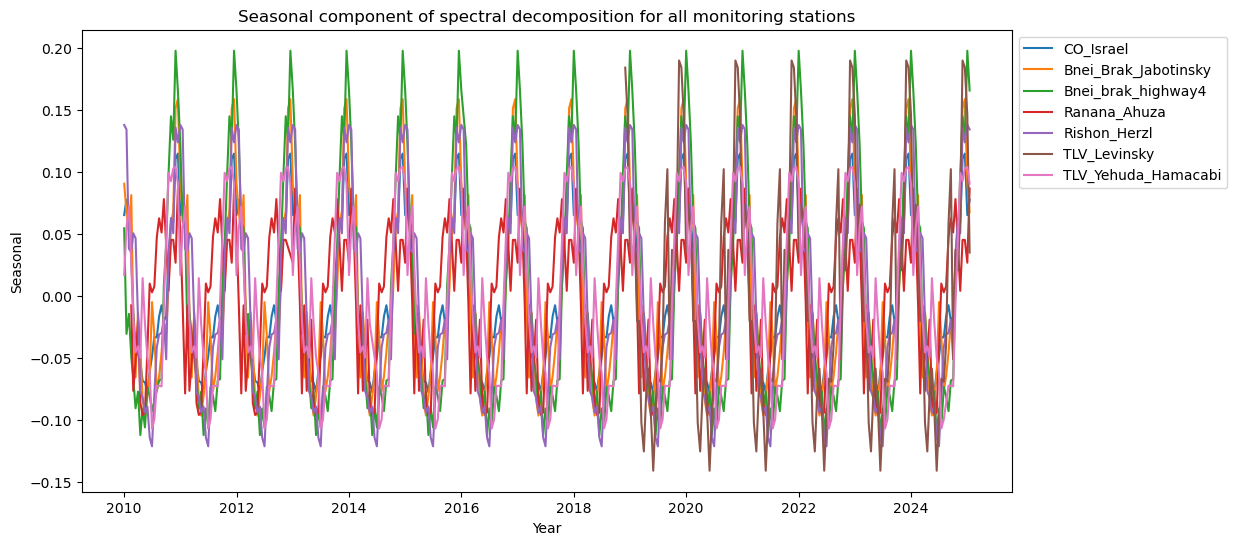

In [13]:
plot_spectral(subset_center, "Seasonal")

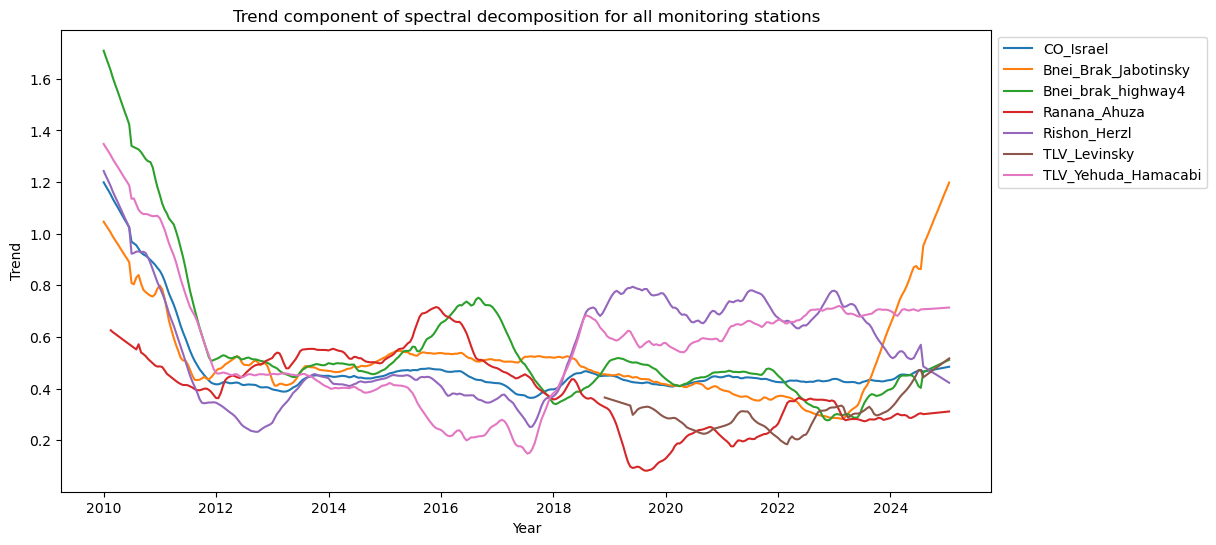

In [14]:
plot_spectral(subset_center, "Trend")

Tasks:
- oberved data from prior 2010
- compare to trends in another cars pollutant

# Monthly average impact

In [15]:
# data preprocessing
air_monthly = df.groupby([
        df['date_time'].dt.year.rename('year'),
        df['date_time'].dt.month.rename('month'),
    ])[df.columns[1:-1]].mean().reset_index()
air_monthly['date'] = pd.to_datetime(air_monthly[['year','month']].assign(day=1))
air_monthly = air_monthly.drop(["year","month"], axis =1)
air_monthly = air_monthly[["date", "CO_Israel", *air_monthly.columns.difference(["date", "CO_Israel"])]]

In [16]:
air_monthly_longer = air_monthly.melt(id_vars=['date'], var_name='station', value_name='CO_level')

In [31]:
air_monthly_decomposition = (
    air_monthly_longer.set_index("station")
    .groupby("station", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=12)
    .reset_index()
)

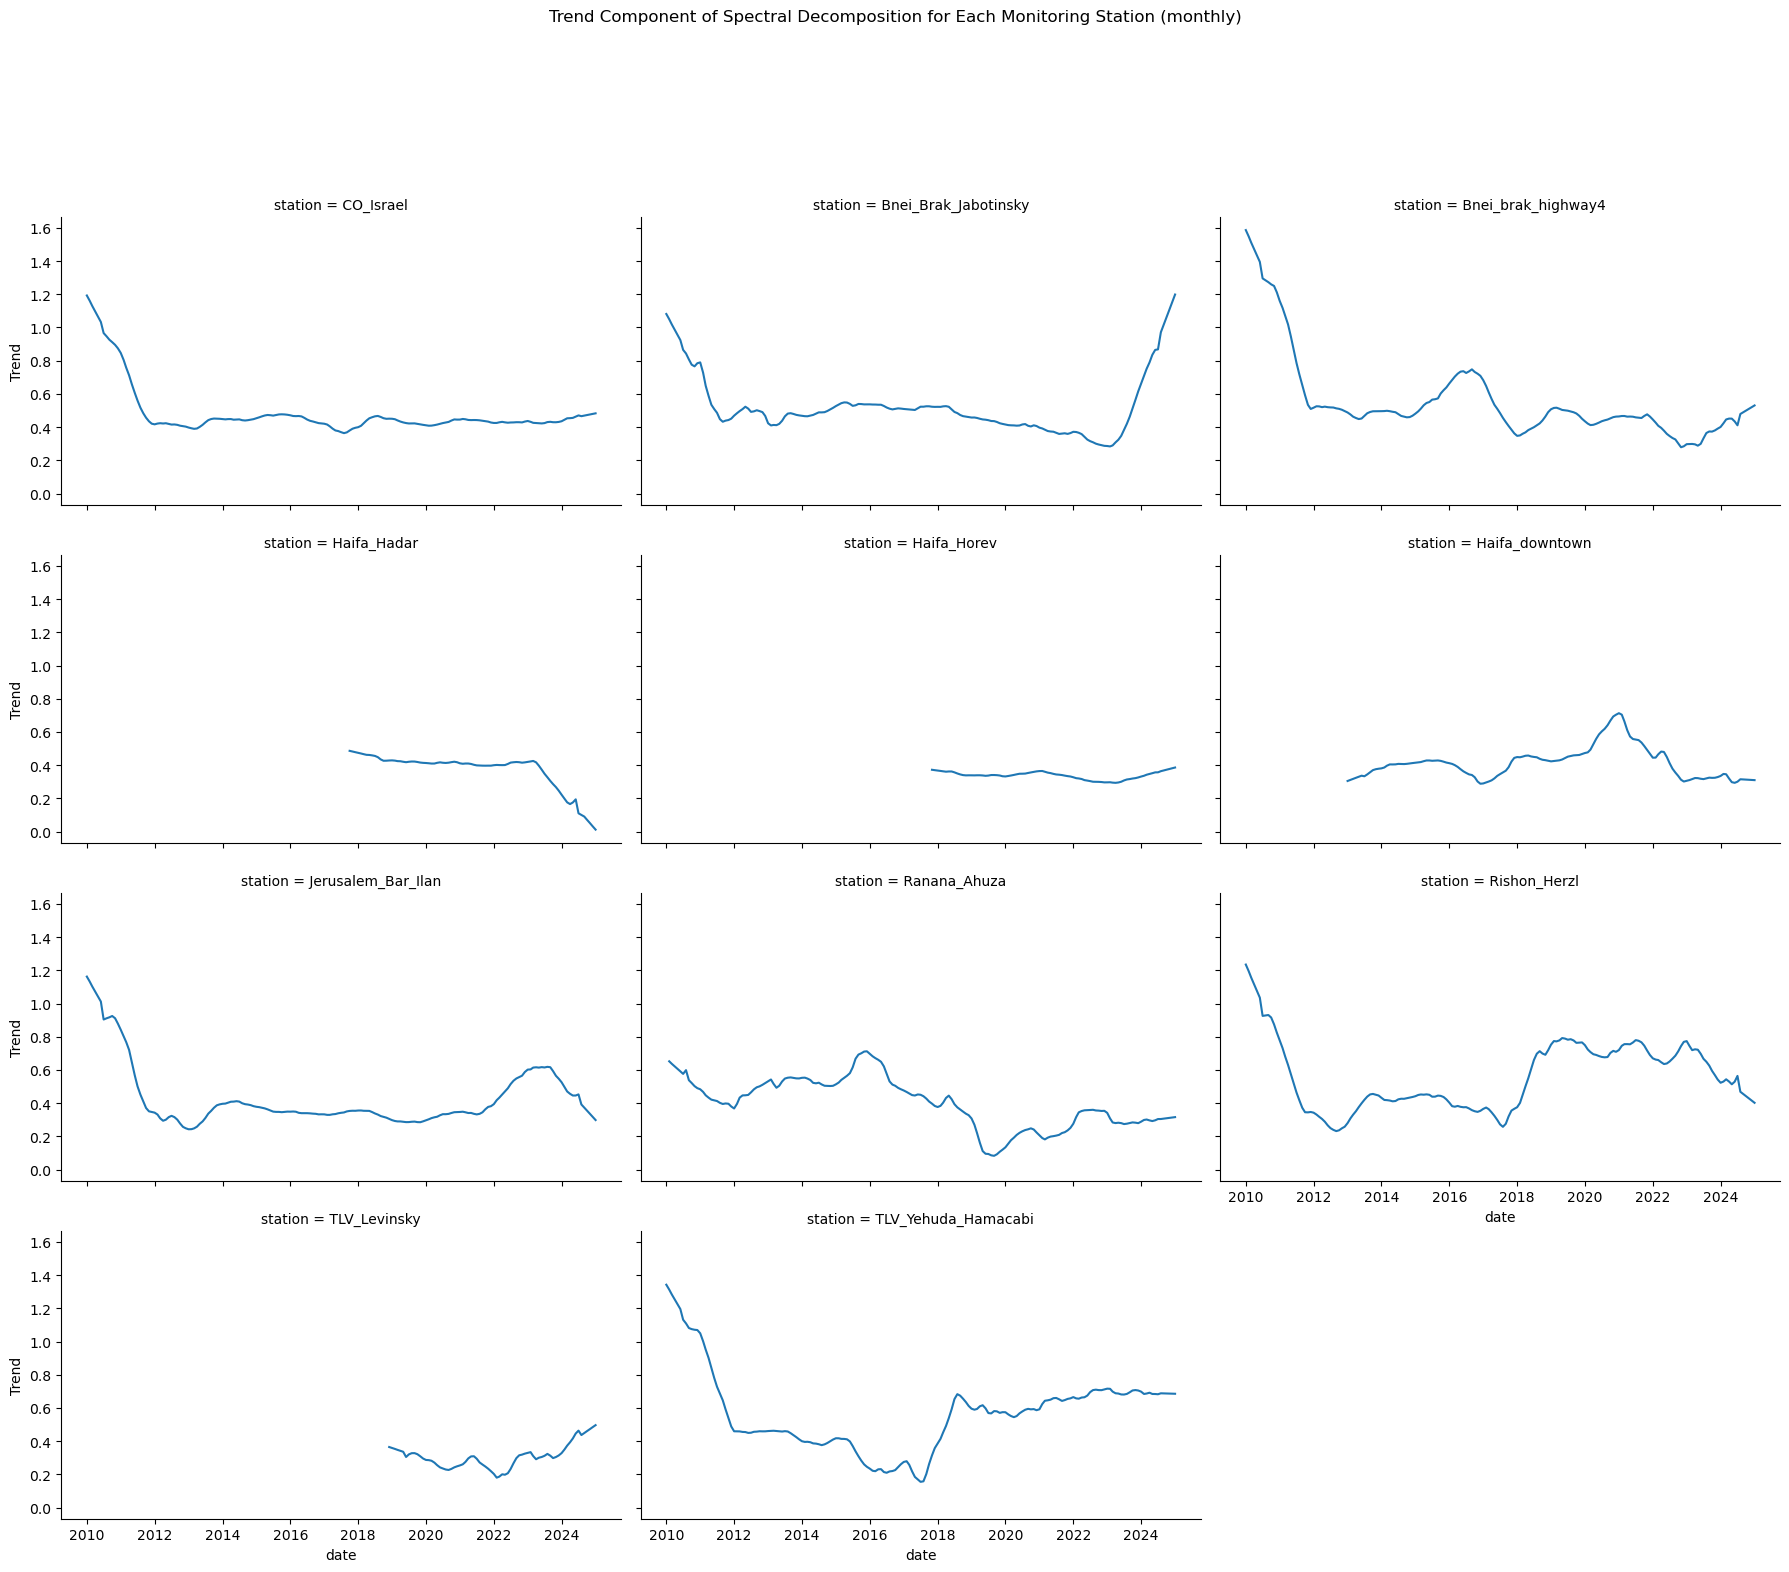

In [41]:
plot_spectral_facets(air_monthly_decomposition, "Trend", "monthly")

Not surprisingly, that looks the same as the half-monthly trends. Lets examine the seasonal components:

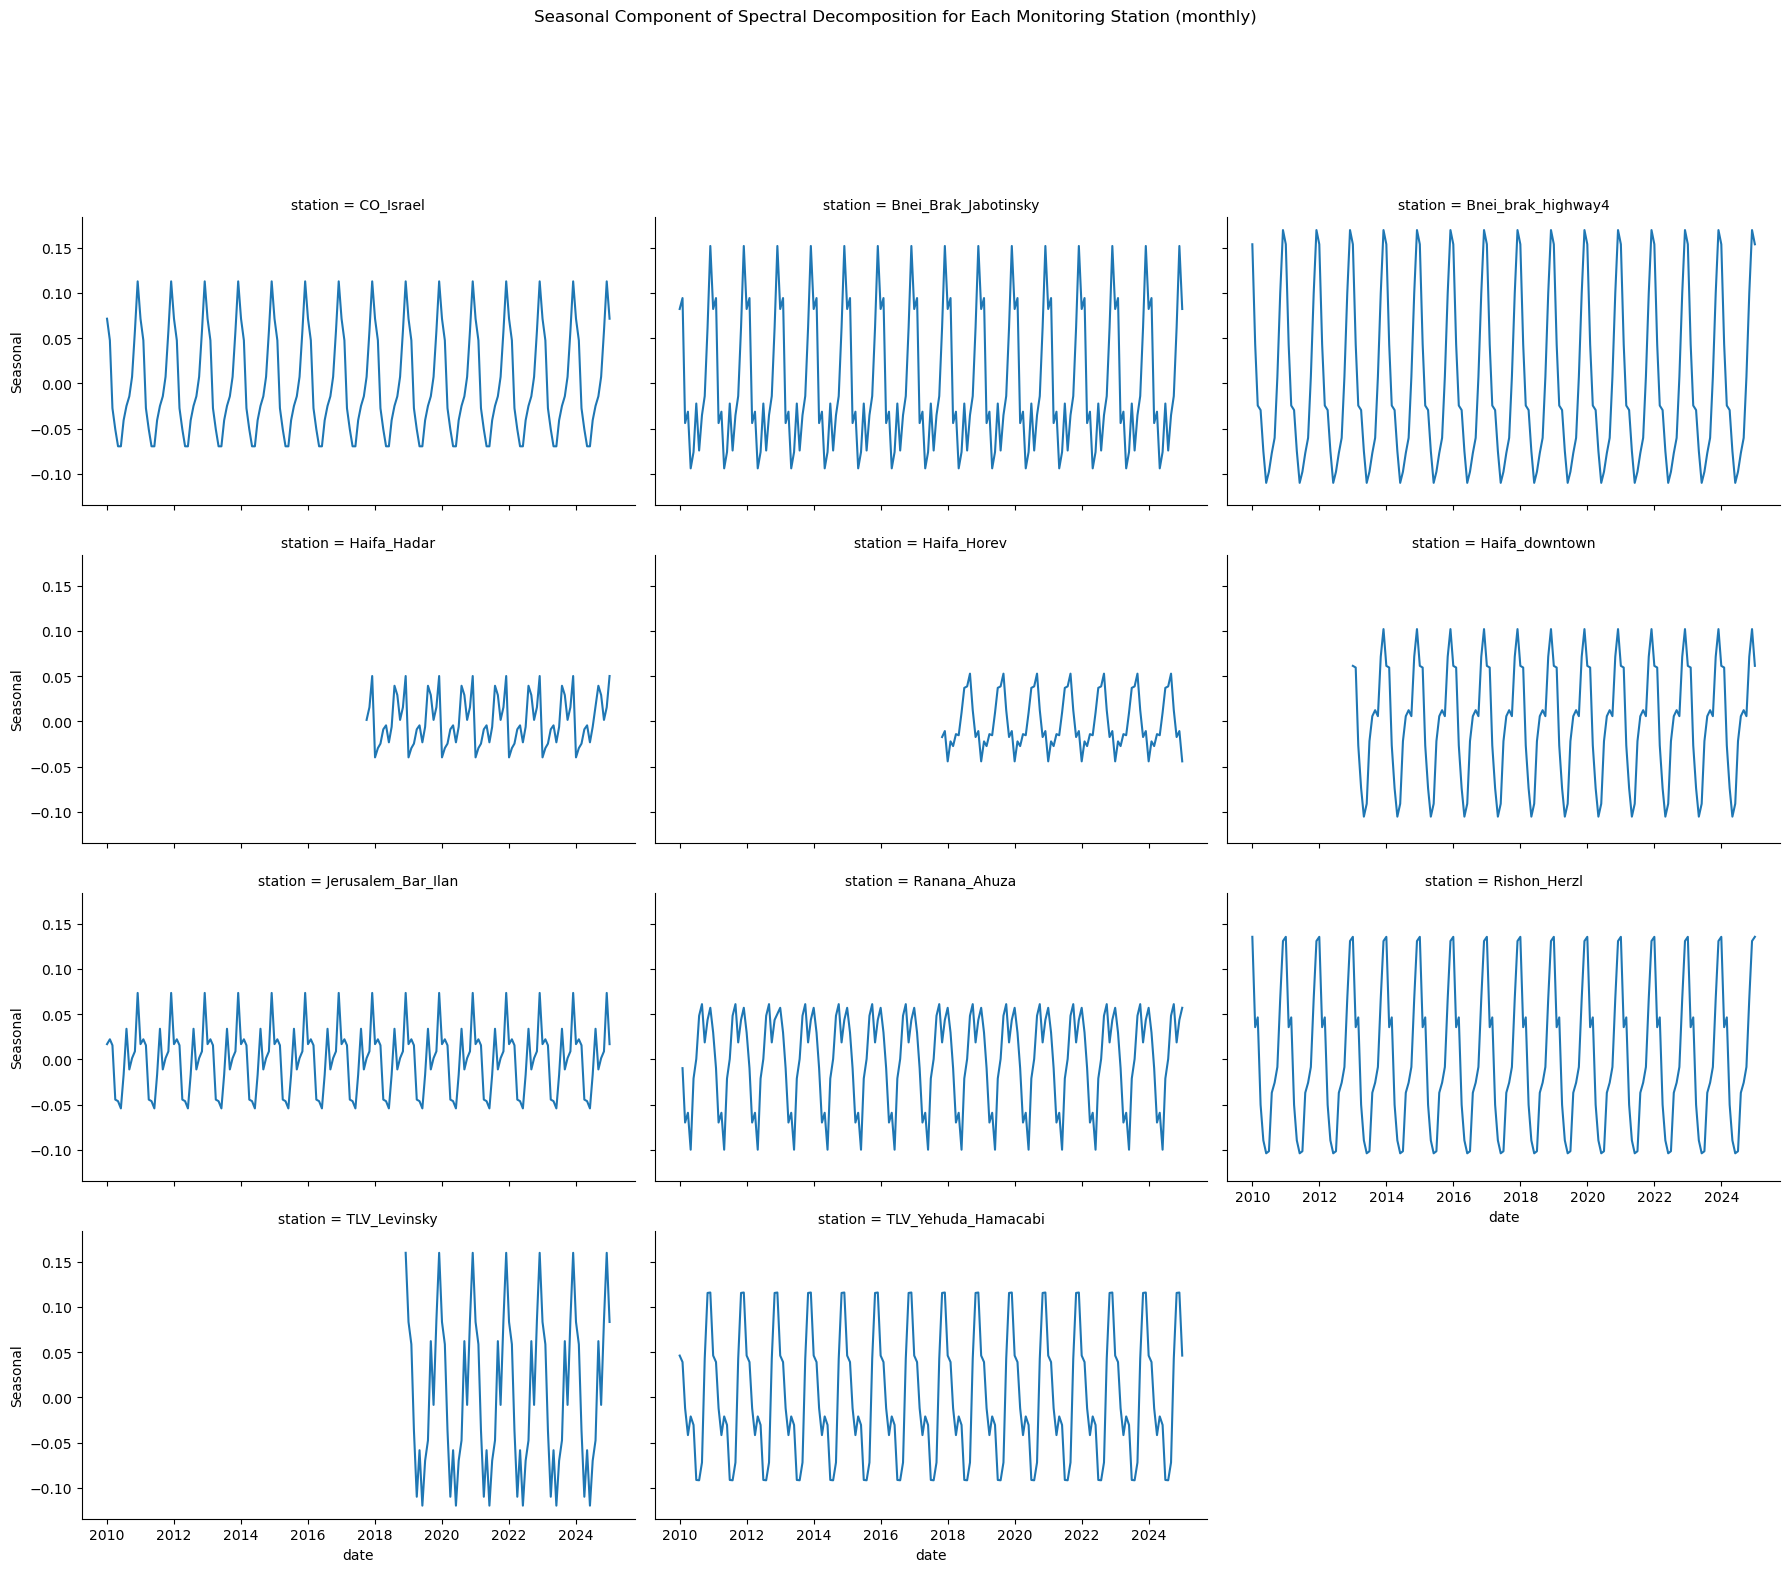

In [42]:
plot_spectral_facets(air_monthly_decomposition, "Seasonal", "monthly")

That is a bit less noisy but still showing the same pattern. Lets try and stack them together:

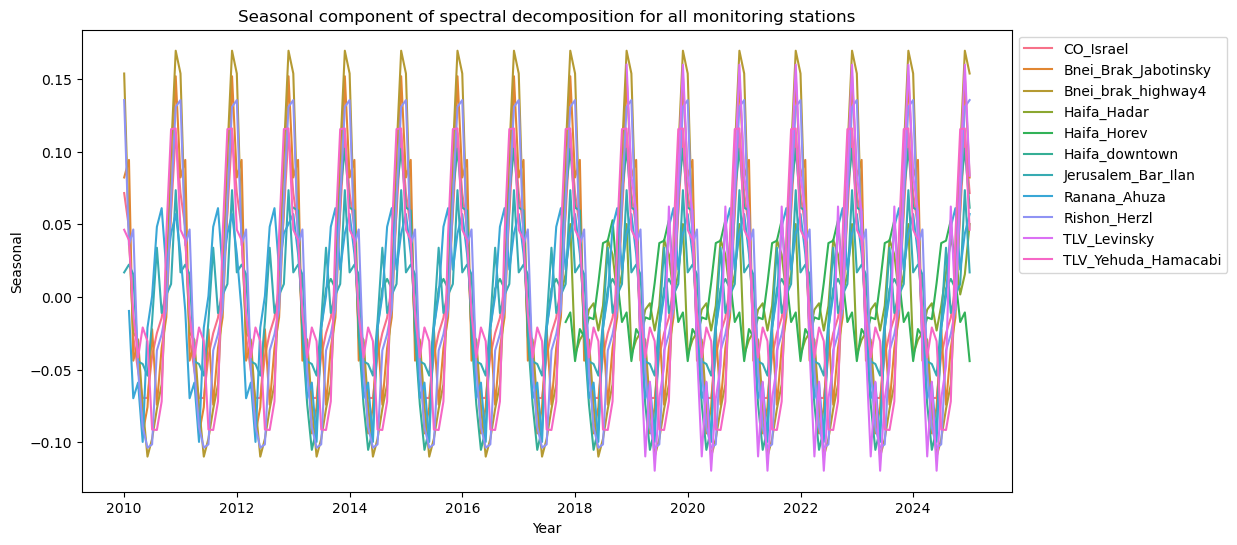

In [43]:
plot_spectral(air_monthly_decomposition, "Seasonal")

Now the individual seasonal trends looks similar, but the station in Haifa still exhibits a prominent deviation. Lets examine the same graph without the Haifa stations:  

In [46]:
air_monthly_decomposition_center = air_monthly_decomposition[~air_monthly_decomposition['station'].str.contains("Haifa", case=False)]

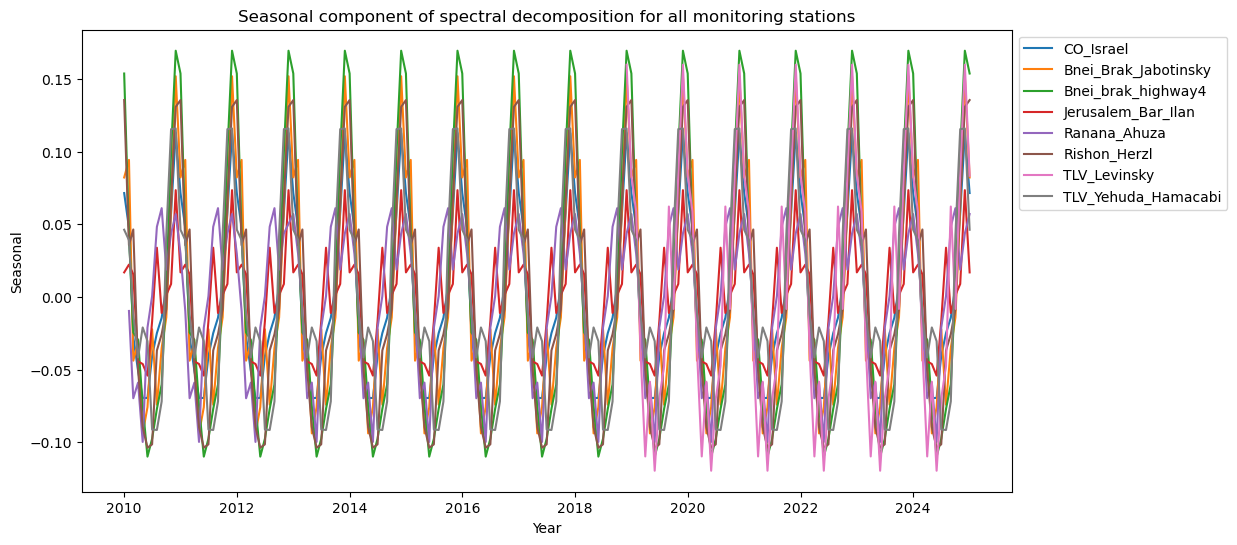

In [47]:
plot_spectral(air_monthly_decomposition_center, "Seasonal")

# What happened before 2010?